In [27]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import progressbar
from multiprocessing import Pool

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/Applications/ANACONDA/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [28]:
# index_col говорим, что индексом будет являться столбец datetime
# parse_dates говорим, что столбец datetime является датой
data = pd.read_csv('train.csv', index_col=['datetime'], parse_dates=['datetime'], dayfirst=True)
data.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [29]:
#  data[['count']] 
newdata = data[['count']] 
newdata.head(5)

,count
datetime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1


## Визуальный анализ ряда

Text(0,0.5,'Количество великов')

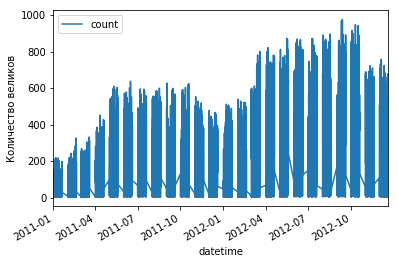

In [30]:
plt.figure(figsize=(15,7))
# почему не сработало newdata.count.plot() ??
newdata.plot()
plt.ylabel('Количество великов')

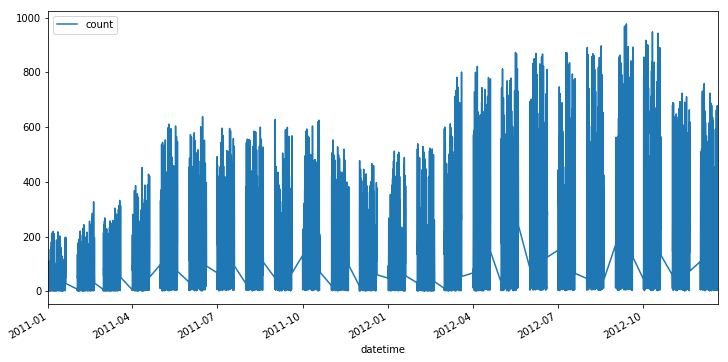

In [31]:
newdata.plot(figsize=(12,6))

In [32]:
# замечаем, что в каждом месяце отсутствуют данные позднее 19го числа
# тут мы оставляем только месяц март
newdata_march = newdata[(newdata.index >= '2011-03-01 00:00:00') & (newdata.index <= '2011-03-19 23:00:00')]
newdata_march.dtypes # типы данных столбцов

count    int64
dtype: object

In [33]:
# меняем имя столбеца count на quantity так как count  оказалось зарезервированным 
newdata_march=newdata_march.rename(columns = {'count':'quantity'})
newdata_march.dtypes

quantity    int64
dtype: object

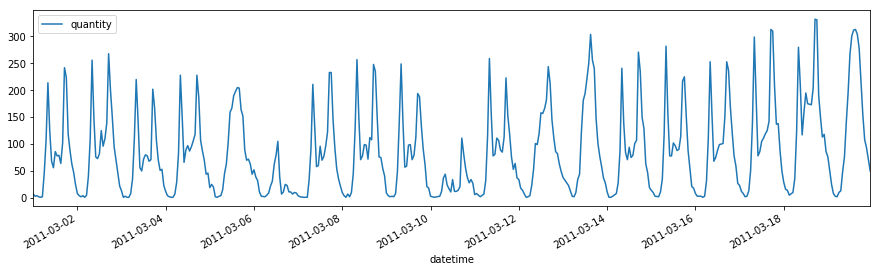

In [34]:
newdata_march.plot(figsize=(15,4)) 

Критерий Дики-Фуллера: p=0.000221


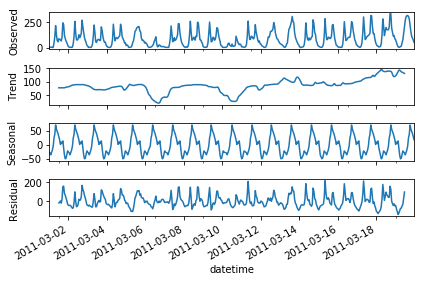

In [35]:
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(newdata_march.quantity, freq=24, model='additive').plot()
# plt.show() # почему-то удаляется 2-я копия графика после этой строки
# удаляется верхняя копия, если после строки seasonal_decompose есть ещё какая-то строка, например как щас print
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(newdata_march.quantity)[1])

## Стабилизация дисперсии
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.338425


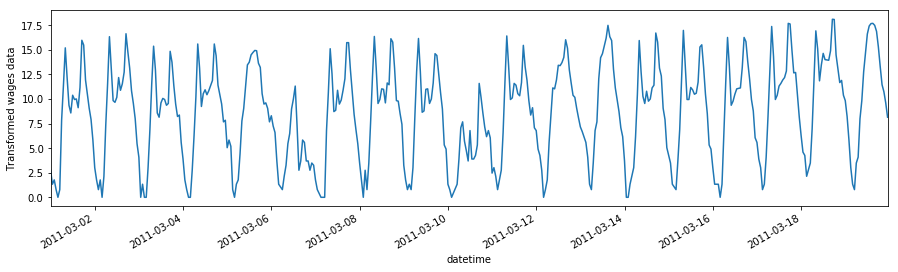

In [36]:
# создаем столбец 'boxcox'
newdata_march['boxcox'], lmbda = stats.boxcox(newdata_march.quantity)
plt.figure(figsize(15,4))
newdata_march.boxcox.plot()
plt.ylabel('Transformed wages data')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

## Выбор порядка дифференцирования
В данных есть тренд и сезонность. Попробуем провести сезонное дифференцирование.

In [37]:
newdata_march.head(5)

,quantity,boxcox
datetime,,
2011-03-01 00:00:00,7,2.753870
2011-03-01 01:00:00,3,1.330693
2011-03-01 02:00:00,4,1.768916
2011-03-01 03:00:00,2,0.781194
2011-03-01 04:00:00,1,0.000000


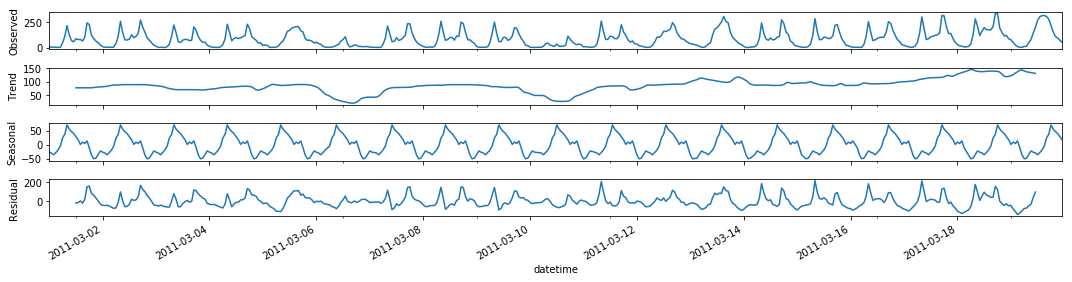

In [38]:
sm.tsa.seasonal_decompose(newdata_march.quantity, freq=24, model='additive').plot()
plt.show()

Критерий Дики-Фуллера: p=0.000001


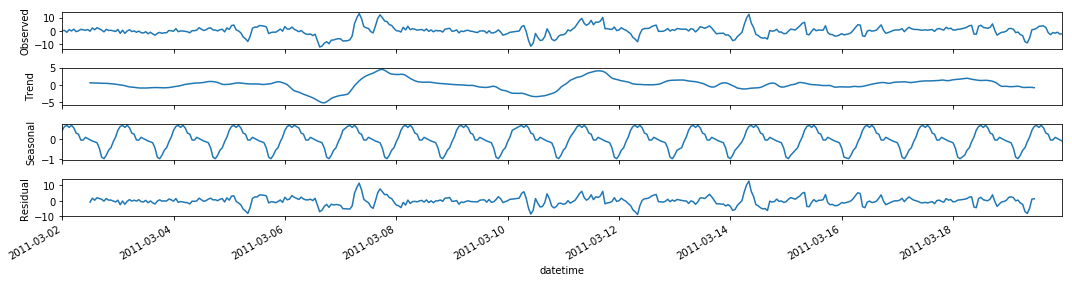

In [39]:
# создаем столбец 'bc_diff_24 '
# дифференцируем из каждого значение вычитаем значение через 24 строки, т.е. через сутки
# del newdata_march['bc_diff_24']
newdata_march['bc_diff_24'] = newdata_march.boxcox - newdata_march.boxcox.shift(24)
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(newdata_march.bc_diff_24[24:], freq=24, model='additive').plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(newdata_march.bc_diff_24[24:])[1])


Критерий Дики-Фуллера: p=0.000001


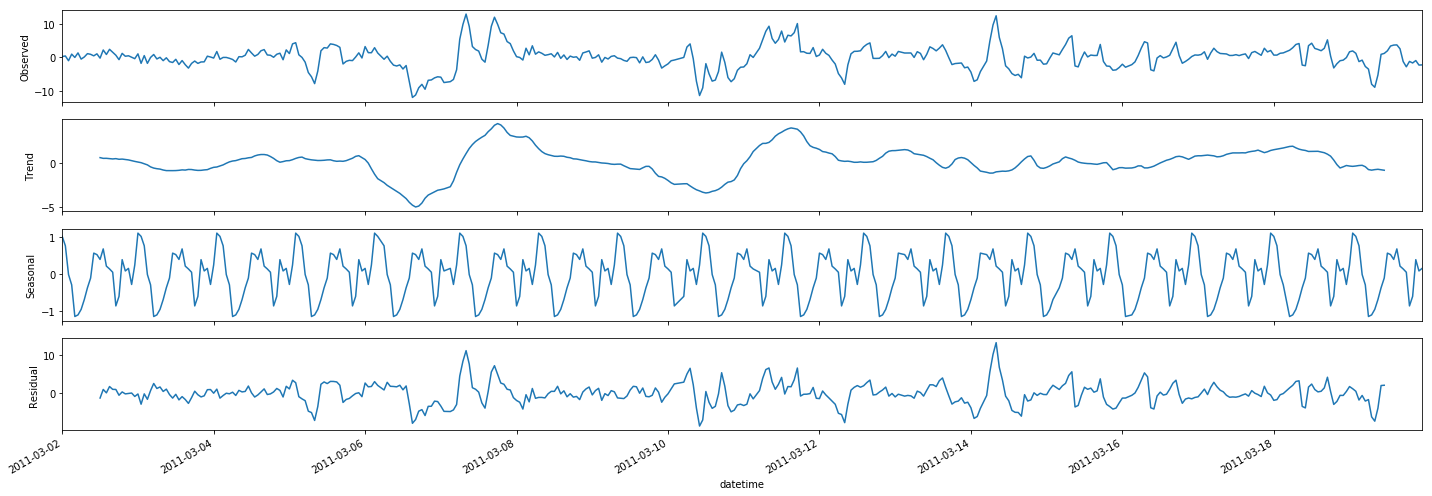

In [61]:
# создаем столбец 'bc_diff_24_1 '
del newdata_march['bc_diff_24_1']
newdata_march['bc_diff_24_1'] = newdata_march.bc_diff_24 - newdata_march.bc_diff_24.shift(1)
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(newdata_march.bc_diff_24[24: ], freq=25, model='additive').plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(newdata_march.bc_diff_24[25: ])[1])

## Выбор начальных приближений для p,q,P,Q
Посмотрим на ACF и PACF полученного ряда:

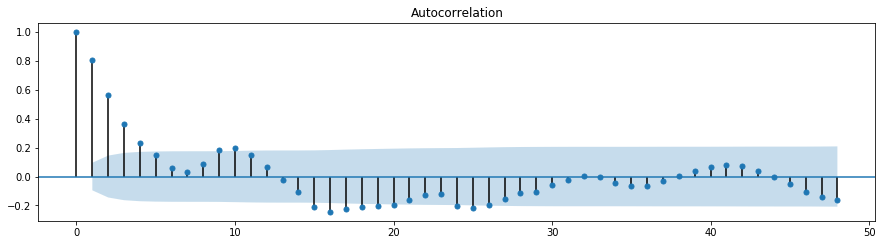

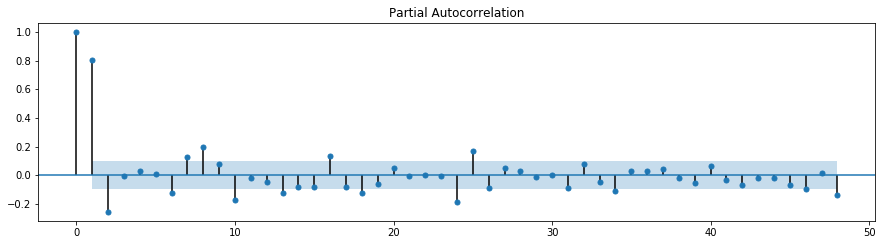

In [62]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(newdata_march.bc_diff_24[25: ].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(newdata_march.bc_diff_24[25: ].values.squeeze(), lags=48, ax=ax)
pylab.show()


Начальные приближения: Q=0, q=0, P=0, p=0
## Обучение и сравнение моделей-кандидатов, выбор победителя
Пусть будет некий trade-off между вычислительной сложностью и начальным приближением.

In [42]:
ps=range(0,5)
d=1
qs=range(0,2)
Ps=range(0,2)
D=1
Qs=range(0,2)

In [43]:
parametrs = product(ps,qs,Ps,Qs)
parameters_list=list(parametrs)
len(parameters_list)

40

In [44]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(newdata_march.boxcox, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print ('wrong parameters: ', param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param,model.aic])

warnings.filterwarnings('default')

wrong parameters:  (0, 0, 0, 0)
wrong parameters:  (2, 1, 0, 0)
wrong parameters:  (2, 1, 0, 1)
wrong parameters:  (2, 1, 1, 0)
wrong parameters:  (2, 1, 1, 1)
CPU times: user 6min 6s, sys: 6.74 s, total: 6min 12s
Wall time: 1min 41s


In [45]:
result_table = pd.DataFrame(results)
result_table.columns = ['parametrs','aic']
print (result_table.sort_values(by='aic',ascending=[True]).head())

       parametrs          aic
26  (3, 1, 1, 1)  1727.812534
24  (3, 1, 0, 1)  1743.388361
25  (3, 1, 1, 0)  1766.517475
30  (4, 0, 1, 1)  1767.044728
34  (4, 1, 1, 1)  1767.275712


In [46]:
print (best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             boxcox   No. Observations:                  446
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -856.906
Date:                            Sat, 11 May 2019   AIC                           1727.813
Time:                                    15:06:22   BIC                           1756.515
Sample:                                03-01-2011   HQIC                          1739.129
                                     - 03-19-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1201      0.046     24.415      0.000       1.030       1.210
ar.L2         -0.3228      0.071   

Критерий Стьюдента: p=0.810055
Критерий Дики-Фуллера: p=0.000000


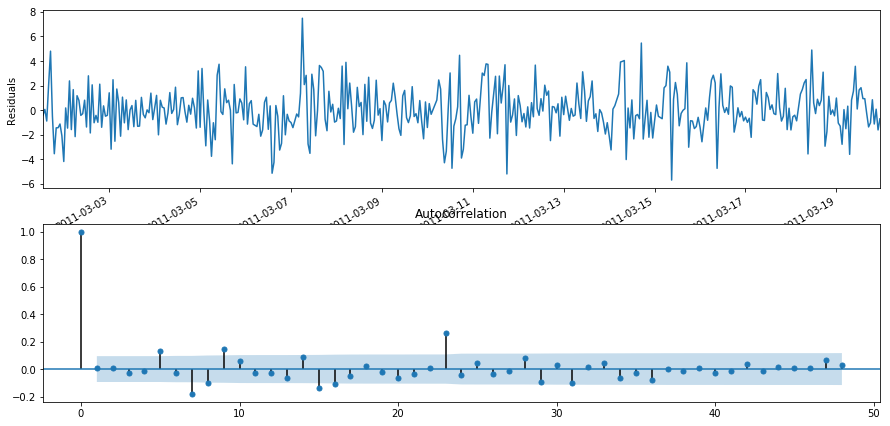

In [47]:
plt.figure(figsize(15,8)) 
plt.subplot(211) 
best_model.resid[13: ].plot() 
plt.ylabel(u'Residuals') 

ax = plt.subplot(212) 
sm.graphics.tsa.plot_acf(best_model.resid[13: ].values.squeeze(), lags=48, ax=ax) 

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13: ], 0)[1]) 
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [48]:
# отдельно напоминаем обратного кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

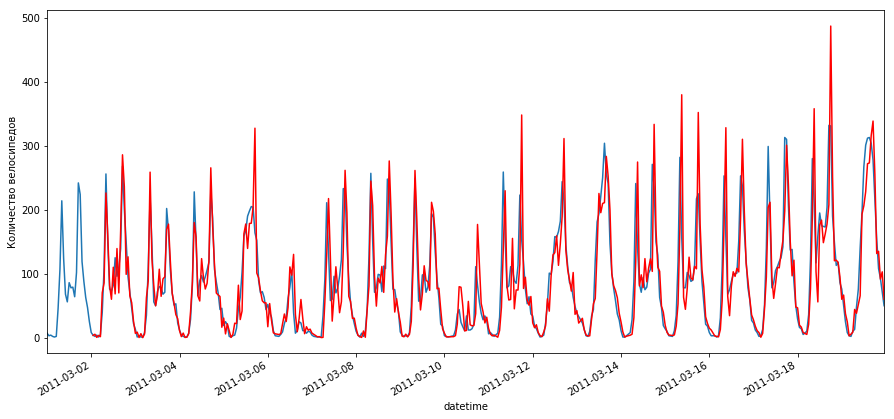

In [49]:
newdata_march['model'] = invboxcox(best_model.fittedvalues, lmbda) 
plt.figure(figsize(15,7)) 
newdata_march.quantity.plot() 
newdata_march.model[25: ].plot(color='r') 
plt.ylabel('Количество велосипедов') 
pylab.show()

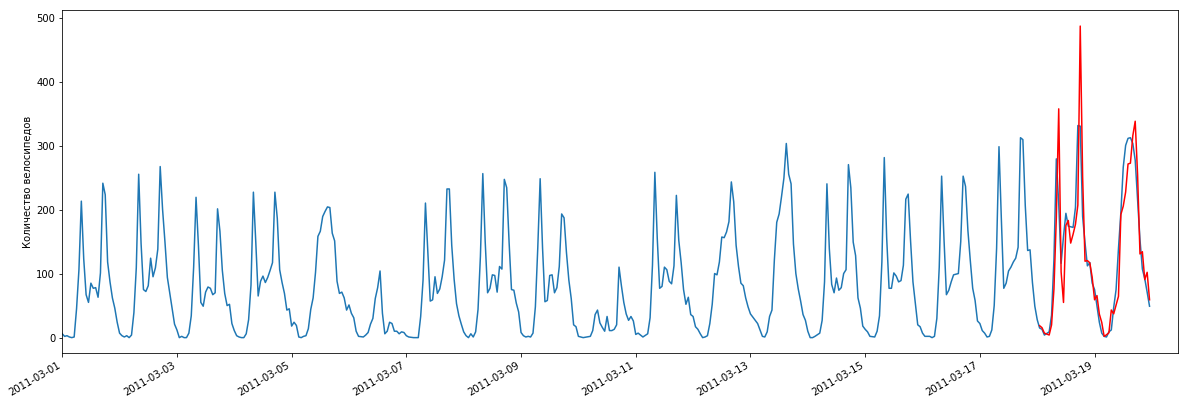

In [56]:
# строим прогноз
newdata_march2=newdata_march[['quantity']] 
# тут выбираем момент начала прогноза 
date_list = [datetime.datetime.strptime("2011-03-20","%Y-%m-%d")+relativedelta(hour=x) for x in range(0,12)] 

future = pd.DataFrame(index=date_list, columns=newdata_march2.columns) 
newdata_march2 = pd.concat([newdata_march2,future]) 

#  первый вариант строит, а второй нет
newdata_march2['forecast']= invboxcox(best_model.predict(start=400, end=445), lmbda) 
#newdata_march2['forecast'] = invboxcox(best_model.predict (start=400, end=500), lmbda)

plt.figure(figsize(20,7)) 
newdata_march2.quantity.plot() 
newdata_march2.forecast.plot(color='r') 
plt.ylabel('Количество велосипедов') 
pylab.show()

In [55]:
newdata_march2['forecast'] = invboxcox(best_model.predict (start=436, end=500), lmbda)

In [64]:
newdata_march2.head(500)

,quantity,forecast
2011-03-01 00:00:00,7,NaN
2011-03-01 01:00:00,3,NaN
2011-03-01 02:00:00,4,NaN
2011-03-01 03:00:00,2,NaN
2011-03-01 04:00:00,1,NaN
2011-03-01 05:00:00,2,NaN
2011-03-01 06:00:00,46,NaN
2011-03-01 07:00:00,107,NaN
2011-03-01 08:00:00,214,NaN
2011-03-01 09:00:00,124,NaN
